
# Iris Classification: EDA → Cleaning → K-NN vs Logistic Regression

**Goal**: Classify Iris flowers into species (*setosa*, *versicolor*, *virginica*) using petal/sepal measurements.  
**Algorithms**: K-Nearest Neighbors (vary k ∈ {1,3,5,7}) and Logistic Regression (baseline).  
**Dataset**: `sklearn.datasets.load_iris` (150 samples, 4 features, 3 classes).

## Setup & Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)


## 1. Load the Iris dataset

In [3]:

iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
feature_names = list(X.columns)
target_names = list(iris.target_names)

df = X.copy()
df["target"] = y
df["target_name"] = df["target"].map(dict(enumerate(target_names)))

print(f"Shape: {df.shape}")
df.head()


Shape: (150, 6)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 2. Basic Exploration

In [4]:

# Dtypes
df.dtypes.to_frame("dtype")


,dtype
sepal length (cm),float64
sepal width (cm),float64
petal length (cm),float64
petal width (cm),float64
target,int64
target_name,object


In [5]:

# Summary statistics for numeric features
df[feature_names].describe().T


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [6]:

# Missing values
df.isna().sum().to_frame("missing_count")


,missing_count
sepal length (cm),0
sepal width (cm),0
petal length (cm),0
petal width (cm),0
target,0
target_name,0


In [7]:

# Class balance
df['target_name'].value_counts().to_frame('count')


,count
target_name,
setosa,50
versicolor,50
virginica,50


## 3. Visualizations (Matplotlib)

### 3.1 Class Balance

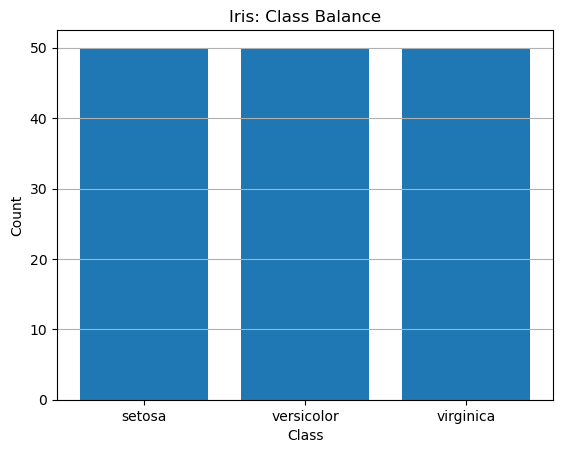

In [8]:

counts = df['target_name'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Iris: Class Balance")
plt.xlabel("Class"); plt.ylabel("Count"); plt.grid(True, axis='y')
plt.show()


### 3.2 Histograms per Feature

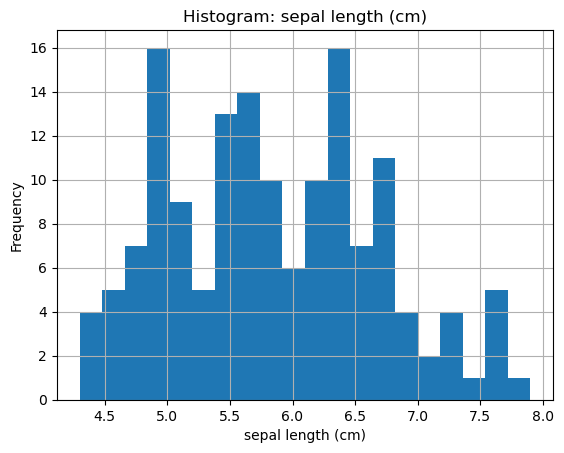

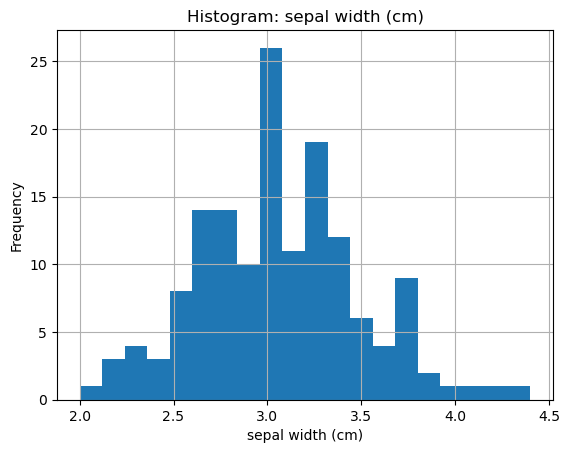

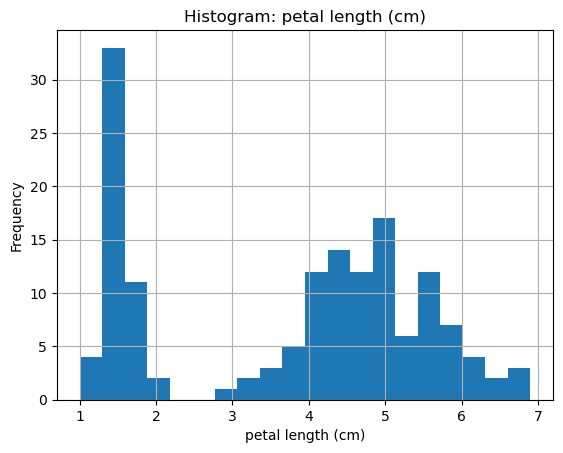

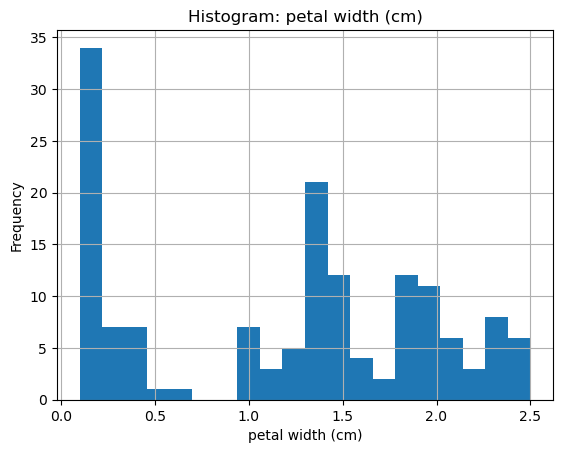

In [9]:

for col in feature_names:
    plt.figure()
    plt.hist(df[col], bins=20)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency"); plt.grid(True)
    plt.show()


### 3.3 Boxplots by Class (each feature)

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_16516\2604335053.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_class, labels=target_names, showfliers=True)


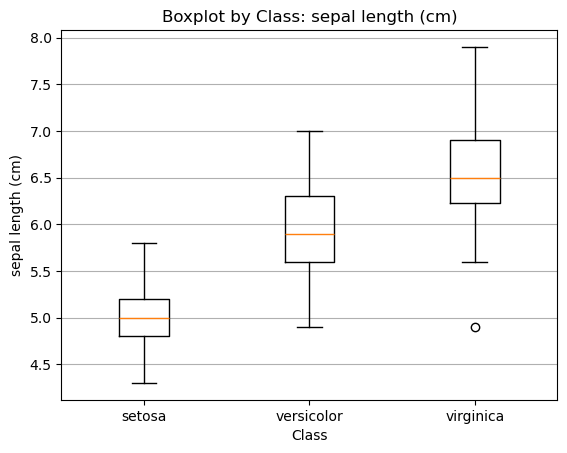

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_16516\2604335053.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_class, labels=target_names, showfliers=True)


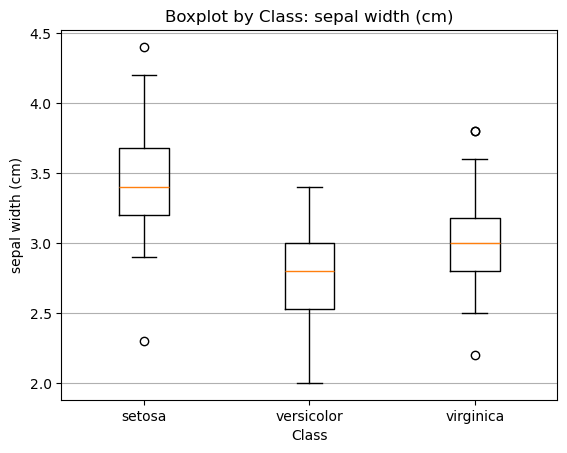

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_16516\2604335053.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_class, labels=target_names, showfliers=True)


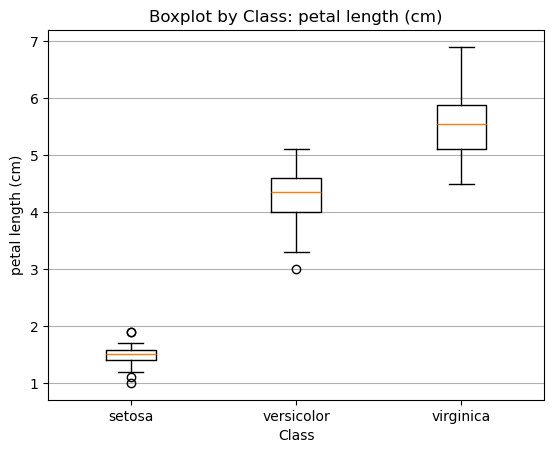

C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_16516\2604335053.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_class, labels=target_names, showfliers=True)


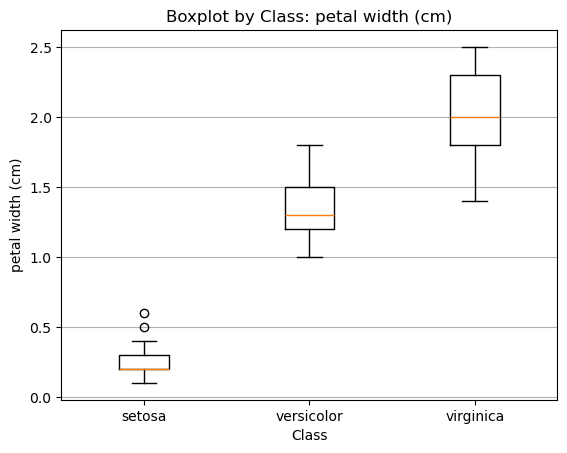

In [10]:

for col in feature_names:
    plt.figure()
    data_by_class = [df.loc[df['target_name']==cls, col].values for cls in target_names]
    plt.boxplot(data_by_class, labels=target_names, showfliers=True)
    plt.title(f"Boxplot by Class: {col}")
    plt.xlabel("Class"); plt.ylabel(col); plt.grid(True, axis='y')
    plt.show()


### 3.4 Scatter Pairs (sepal & petal)

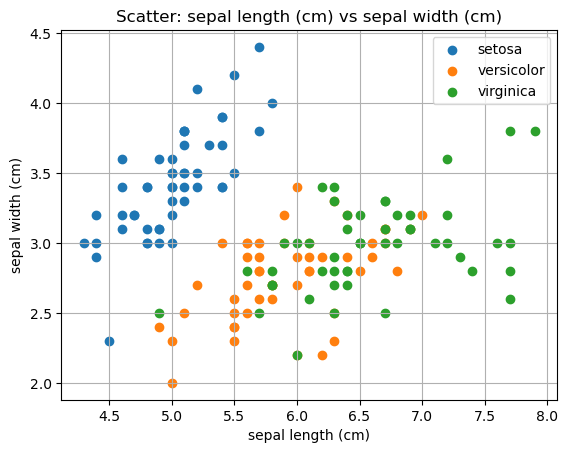

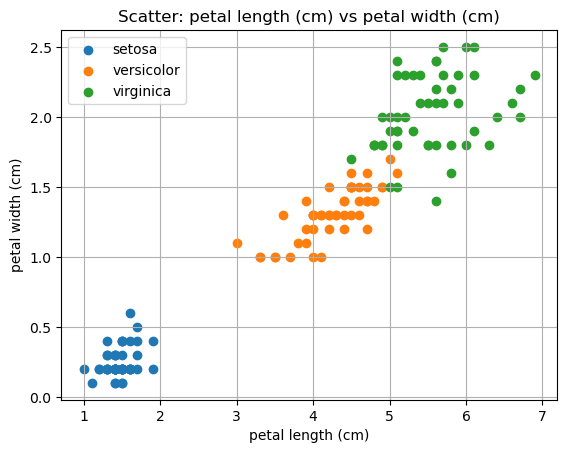

In [11]:

pairs = [
    ("sepal length (cm)", "sepal width (cm)"),
    ("petal length (cm)", "petal width (cm)"),
]
for x_col, y_col in pairs:
    plt.figure()
    for cls in target_names:
        mask = df['target_name'] == cls
        plt.scatter(df.loc[mask, x_col], df.loc[mask, y_col], label=cls)
    plt.title(f"Scatter: {x_col} vs {y_col}")
    plt.xlabel(x_col); plt.ylabel(y_col)
    plt.legend(); plt.grid(True)
    plt.show()


### 3.5 Correlation Heatmap

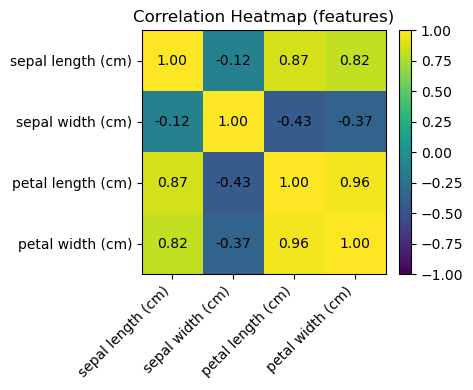

In [12]:

corr = df[feature_names].corr()
plt.figure(figsize=(5,4))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (features)")
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar(im, fraction=0.046, pad=0.04)
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()


## 4. Data Quality Checks

In [13]:
# Duplicates
n_dups = int(df.duplicated().sum())
print("Exact duplicates:", n_dups)

Exact duplicates: 1


In [14]:
# Non-positive values (safety check)
non_positive = (df[feature_names] <= 0).sum()
print("\nNon-positive value counts per feature:")
print(non_positive.to_string())


Non-positive value counts per feature:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0


In [15]:
# Simple outlier flag (z-score > 3)
z = (df[feature_names] - df[feature_names].mean()) / df[feature_names].std(ddof=0)
outlier_mask = (np.abs(z) > 3).any(axis=1)
print("\nRows flagged as potential outliers (|z|>3):", int(outlier_mask.sum()))



Rows flagged as potential outliers (|z|>3): 1


## 5. Cleaning (drop duplicates and enforce positive values)

In [16]:

cleaned = df.drop_duplicates().copy()
for col in feature_names:
    cleaned = cleaned[cleaned[col] > 0]

rows_removed = df.shape[0] - cleaned.shape[0]
print("Rows removed during cleaning:", rows_removed)
cleaned.head()


Rows removed during cleaning: 1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [17]:
# Save cleaned dataset
CLEAN_PATH = "iris_cleaned.csv"
cleaned.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned CSV to:", CLEAN_PATH)


Saved cleaned CSV to: iris_cleaned.csv


## 6. Modeling: Train/Test Split, K-NN (k=1,3,5,7) vs Logistic Regression

In [18]:
# Use cleaned features/labels
X_clean = cleaned[feature_names]
y_clean = cleaned["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

ks = [1, 3, 5, 7]
results = []
knn_preds = {}

for k in ks:
    model = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    results.append({"Model": f"KNN (k={k})", "k": k, "Accuracy": acc})
    knn_preds[k] = pred

In [19]:
# Logistic Regression baseline
lr = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=1000))])
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
results.append({"Model": "Logistic Regression", "k": None, "Accuracy": lr_acc})

results_df = pd.DataFrame(results).sort_values(by=["k"], na_position="last")
results_df


,Model,k,Accuracy
0,KNN (k=1),1.0,0.966667
1,KNN (k=3),3.0,0.933333
2,KNN (k=5),5.0,0.933333
3,KNN (k=7),7.0,0.966667
4,Logistic Regression,NaN,0.933333


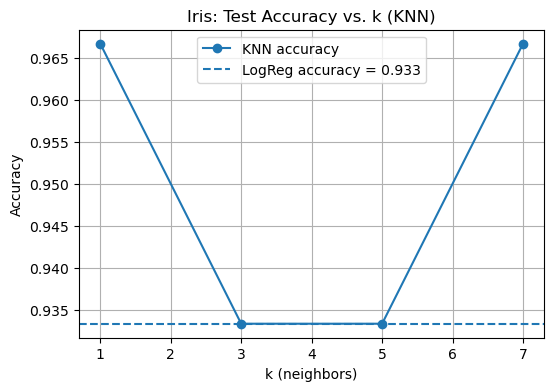

In [20]:
# Plot accuracy vs k (with LR baseline)
plt.figure(figsize=(6,4))
plt.plot([r["k"] for r in results if r["k"] in ks],
         [r["Accuracy"] for r in results if r["k"] in ks],
         marker="o", label="KNN accuracy")
plt.axhline(y=lr_acc, linestyle="--", label=f"LogReg accuracy = {lr_acc:.3f}")
plt.title("Iris: Test Accuracy vs. k (KNN)")
plt.xlabel("k (neighbors)"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()


In [21]:
# Confusion matrices: best KNN and LogReg
best_k = max(ks, key=lambda k: accuracy_score(y_test, knn_preds[k]))
print(f"Best KNN: k={best_k}, accuracy={accuracy_score(y_test, knn_preds[best_k]):.3f}")
print(f"Logistic Regression accuracy: {lr_acc:.3f}")

Best KNN: k=1, accuracy=0.967
Logistic Regression accuracy: 0.933


<Figure size 500x400 with 0 Axes>

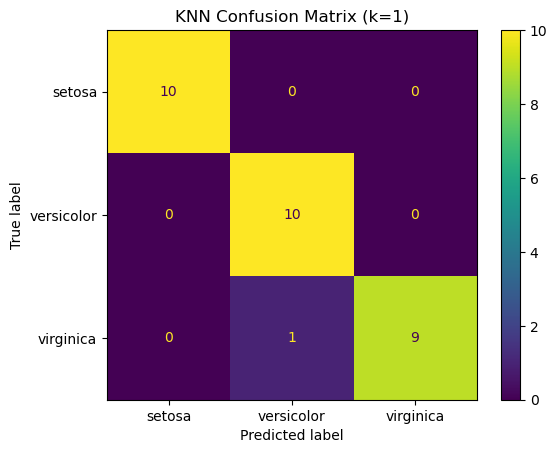

In [22]:
# Best KNN confusion matrix
cm_knn = confusion_matrix(y_test, knn_preds[best_k])
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=target_names).plot(values_format="d")
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.show()

<Figure size 500x400 with 0 Axes>

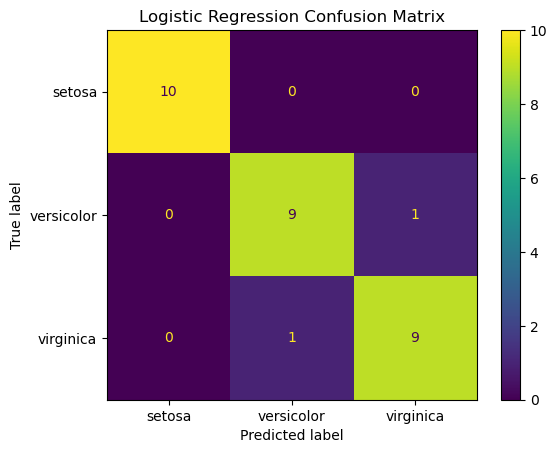

In [23]:
# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=target_names).plot(values_format="d")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [24]:
# Classification reports
print("\nClassification Report - Logistic Regression")
print(classification_report(y_test, lr_pred, target_names=target_names))

print("\nClassification Report - Best KNN")
print(classification_report(y_test, knn_preds[best_k], target_names=target_names))



Classification Report - Logistic Regression
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Classification Report - Best KNN
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [25]:
# Save results to CSV
RESULTS_PATH = "iris_knn_vs_lr_test_accuracy.csv"
results_df.to_csv(RESULTS_PATH, index=False)
print("Saved results CSV to:", RESULTS_PATH)

Saved results CSV to: iris_knn_vs_lr_test_accuracy.csv
